In [1]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, MaxPooling1D, Conv1D
from tensorflow.keras.optimizers import Adam, SGD
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from sklearn import metrics
import random
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import optimizers
import datetime
import matplotlib.pyplot as plt 

import librosa
import librosa.display
import noisereduce as nr
import soundfile as sf

In [2]:
def plotAudio2(output):
    fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,4)) #figsize=20,4
    plt.plot(output, color='blue')
    ax.set_xlim((0, len(output)))
    plt.show()

def draw_spectrogram(X):
    #X = librosa.effects.preemphasis(X)
    #clip, index = librosa.effects.trim(X, top_db=20, hop_length=256)
    stfts = librosa.stft(X, n_fft=512, hop_length=256, win_length=512)   
    stftsdb = librosa.amplitude_to_db(abs(stfts))
    plt.figure(figsize=(20,4))
    librosa.display.specshow(stftsdb, sr=16000, 
                             hop_length=256,
                             x_axis='s', y_axis='hz')
    plt.colorbar()

In [3]:
def minMaxNormalize(arr):
    mn = np.min(arr)
    mx = np.max(arr)
    return (arr-mn)/(mx-mn)

In [4]:
def get_data(path, sampleSize):
    
    #Category
    OtherSound = 'OtherSound'
    Speaking = 'Speaking'
    
    X = []
    y = []
    
    
    for file in os.listdir(path):
        a = (np.load(path + "/" + file)).T
        a = np.nan_to_num(a, copy=False)
        a = np.mean(a, axis=0)
        
        ### Normalizing
        a = minMaxNormalize(a)
        
        label = file.split('_')[-1].split(".")[0]
        if label == OtherSound:
#             print(file, 'It is OtherSound file')
            label="OtherSound"
            X.append(a)
            y.append(label)
            
        elif label == Speaking:
#             print(file, 'It is Speaking file')
            label="Speaking"
            X.append(a)
            y.append(label)
            

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle = True, random_state=123)
    
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    X_train = np.nan_to_num(X_train, copy=False)
    y_train = np.nan_to_num(y_train, copy=False)
    X_test = np.nan_to_num(X_test, copy=False)
    y_test = np.nan_to_num(y_test, copy=False)
    
    # delete overlap
    X_train, overlap_index = np.unique(X_train, axis=0, return_index=True)
    y_train = y_train[overlap_index]

    X_test, overlap_index = np.unique(X_test, axis=0, return_index=True)
    y_test = y_test[overlap_index]

    
    return X_train, y_train, X_test, y_test

In [5]:
def print_M(conf_M): #???
    s = "activity:"
    for i in range(len(conf_M)):
        s += lb.inverse_transform([i])[0] + ","
    print(s[:-1])
    for i in range(len(conf_M)):
        s = ""
        for j in range(len(conf_M)):
            s += str(conf_M[i][j])
            s += ","
        print(lb.inverse_transform([i])[0], ",", s[:-1])
    print()
    
def print_M_P(conf_M):
    s = "activity:"
    for i in range(len(conf_M)):
        s += lb.inverse_transform([i])[0] + ","
    print(s[:-1])
    for i in range(len(conf_M)):
        s = ""
        for j in range(len(conf_M)):
            val = conf_M[i][j] / float(sum(conf_M[i]))
            s += str(round(val, 2))
            s += ","
        print(lb.inverse_transform([i])[0], ",", s[:-1])
    print()
    
    
def showResult():
    predictions = [np.argmax(y) for y in result]
    expected = [np.argmax(y) for y in y_test]

    conf_M = [] #예측값 개수, 실젯값 개수
    num_labels = y_test[0].shape[0]
    for i in range(num_labels):
        r = []
        for j in range(num_labels):
            r.append(0)
        conf_M.append(r)
    print("initial value of conf_M: ", conf_M)

    n_tests = len(predictions)
    for i in range(n_tests):
        conf_M[expected[i]][predictions[i]] += 1

    print("conf_M: ", conf_M)
    print_M(conf_M)
    print_M_P(conf_M)
    print("label 개수: ", num_labels)


In [6]:
featuresPath = "/home/bongseok/Desktop/speaking_detector/STFT_features"

X_train, y_train, X_test, y_test = get_data(featuresPath, 250) # 학습데이터 구축, samplesize=250

/home/bongseok/venv3.5/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


In [7]:
len(y_train) + len(y_test)

108972

In [8]:
print(len(y_train), len(y_test))

97981 10991


In [9]:
y_train.shape

(97981,)

In [10]:
y_test.shape

(10991,)

In [11]:
y_train

array(['OtherSound', 'OtherSound', 'OtherSound', ..., 'OtherSound',
       'OtherSound', 'OtherSound'], dtype='<U10')

In [12]:
X_train.shape

(97981, 257)

In [13]:
n_samples = len(y_train)
print("Num of training samples: " + str(n_samples))
order = np.array(range(n_samples))
np.random.shuffle(order)
X_train = X_train[order]
y_train = y_train[order]

Num of training samples: 97981


In [14]:
lb = LabelEncoder() 
y_train = np_utils.to_categorical(lb.fit_transform(y_train)) # fit_transform: Fit label encoder and return encoded labels
y_test = np_utils.to_categorical(lb.fit_transform(y_test))


num_labels = y_train.shape[1]
num_labels

2

In [15]:
oth_count = 0
spe_count = 0
for i in y_train:
    if i[0] == 0.:
        oth_count +=1
    elif i[0] == 1.:
        spe_count +=1
print(oth_count, spe_count)

47129 50852


In [16]:
oth_count = 0
spe_count = 0
for i in y_test:
    if i[0] == 0.:
        oth_count +=1
    elif i[0] == 1.:
        spe_count +=1
print(oth_count, spe_count)

5308 5683


In [17]:
# # inverse_transform: Transform labels back to original encoding
# lb.inverse_transform([0, 1]) 

In [18]:
# Check Nan or Inf
for i in X_train:
    if np.isfinite(i.any()) == False:
        print('false')

In [19]:
for i in X_test:
    if np.isfinite(i.any()) == False:
        print('false')

In [20]:
print(len(X_test[2]))
print(len(X_test[3]))

257
257


In [21]:
X_train.shape

(97981, 257)

In [22]:
X_test.shape

(10991, 257)

In [23]:
y_train.shape

(97981, 2)

In [24]:
y_test.shape

(10991, 2)

In [25]:
# build model


opt = optimizers.Adam(learning_rate=0.001)

metrics = [#tf.keras.metrics.TruePositives(name='TP'),
           #tf.keras.metrics.FalsePositives(name='FP'),
           #tf.keras.metrics.TrueNegatives(name='TN'),
           #tf.keras.metrics.FalseNegatives(name='FN'),
           tf.keras.metrics.BinaryAccuracy(name='accuracy'),
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall'),
tf.keras.metrics.AUC(name='auc')]


model = Sequential()

model.add(Dense(256, input_shape=(257,)))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(num_labels))
model.add(Activation('softmax'))

model.compile(loss='binary_crossentropy', metrics=metrics, optimizer=opt)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               66048     
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               3

In [26]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=10) # , patience=5
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)


history = model.fit(X_train, y_train, 
                    batch_size=512, 
                    epochs=100,
                    validation_split=0.1, callbacks=[es])
#callbacks=[es, mc]
result = model.predict(X_test)

Epoch 1/100
173/173 [==============================] - 2s 10ms/step - recall: 0.8616 - loss: 0.3432 - auc: 0.9282 - precision: 0.8616 - accuracy: 0.8616 - val_precision: 0.9108 - val_accuracy: 0.9108 - val_recall: 0.9108 - val_auc: 0.9614 - val_loss: 0.2471
Epoch 2/100
173/173 [==============================] - 2s 9ms/step - recall: 0.9073 - loss: 0.2445 - auc: 0.9627 - precision: 0.9073 - accuracy: 0.9073 - val_precision: 0.9133 - val_accuracy: 0.9133 - val_recall: 0.9133 - val_auc: 0.9685 - val_loss: 0.2269
Epoch 3/100
173/173 [==============================] - 1s 8ms/step - recall: 0.9187 - loss: 0.2141 - auc: 0.9714 - precision: 0.9187 - accuracy: 0.9187 - val_precision: 0.9265 - val_accuracy: 0.9265 - val_recall: 0.9265 - val_auc: 0.9732 - val_loss: 0.2038
Epoch 4/100
173/173 [==============================] - 1s 9ms/step - recall: 0.9257 - loss: 0.1962 - auc: 0.9760 - precision: 0.9257 - accuracy: 0.9257 - val_precision: 0.9345 - val_accuracy: 0.9345 - val_recall: 0.9345 - val_au

Epoch 33/100
173/173 [==============================] - 1s 8ms/step - recall: 0.9657 - loss: 0.0917 - auc: 0.9945 - precision: 0.9657 - accuracy: 0.9657 - val_precision: 0.9672 - val_accuracy: 0.9672 - val_recall: 0.9672 - val_auc: 0.9937 - val_loss: 0.0957
Epoch 34/100
173/173 [==============================] - 1s 8ms/step - recall: 0.9665 - loss: 0.0909 - auc: 0.9946 - precision: 0.9665 - accuracy: 0.9665 - val_precision: 0.9660 - val_accuracy: 0.9660 - val_recall: 0.9660 - val_auc: 0.9939 - val_loss: 0.0951
Epoch 35/100
173/173 [==============================] - 1s 8ms/step - recall: 0.9666 - loss: 0.0896 - auc: 0.9947 - precision: 0.9666 - accuracy: 0.9666 - val_precision: 0.9659 - val_accuracy: 0.9659 - val_recall: 0.9659 - val_auc: 0.9940 - val_loss: 0.0947
Epoch 36/100
173/173 [==============================] - 2s 10ms/step - recall: 0.9675 - loss: 0.0873 - auc: 0.9950 - precision: 0.9675 - accuracy: 0.9675 - val_precision: 0.9672 - val_accuracy: 0.9672 - val_recall: 0.9672 - va

Epoch 65/100
173/173 [==============================] - 2s 9ms/step - recall: 0.9750 - loss: 0.0696 - auc: 0.9966 - precision: 0.9750 - accuracy: 0.9750 - val_precision: 0.9727 - val_accuracy: 0.9727 - val_recall: 0.9727 - val_auc: 0.9952 - val_loss: 0.0816
Epoch 66/100
173/173 [==============================] - 1s 8ms/step - recall: 0.9748 - loss: 0.0700 - auc: 0.9966 - precision: 0.9748 - accuracy: 0.9748 - val_precision: 0.9738 - val_accuracy: 0.9738 - val_recall: 0.9738 - val_auc: 0.9950 - val_loss: 0.0803
Epoch 67/100
173/173 [==============================] - 1s 8ms/step - recall: 0.9760 - loss: 0.0672 - auc: 0.9969 - precision: 0.9760 - accuracy: 0.9760 - val_precision: 0.9737 - val_accuracy: 0.9737 - val_recall: 0.9737 - val_auc: 0.9949 - val_loss: 0.0816
Epoch 68/100
173/173 [==============================] - 2s 9ms/step - recall: 0.9752 - loss: 0.0685 - auc: 0.9968 - precision: 0.9752 - accuracy: 0.9752 - val_precision: 0.9747 - val_accuracy: 0.9747 - val_recall: 0.9747 - val

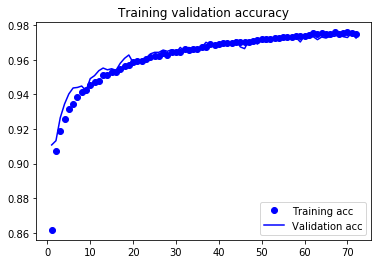

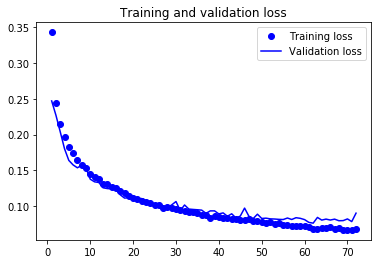

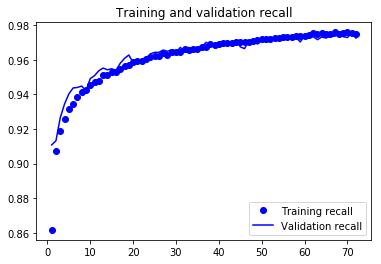

<Figure size 432x288 with 0 Axes>

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

recall = history.history['recall']
val_recall = history.history['val_recall']



epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.figure()

plt.plot(epochs, recall, 'bo', label='Training recall')
plt.plot(epochs, val_recall, 'b', label='Validation recall')
plt.title('Training and validation recall')
plt.legend()

plt.figure()

# plt.plot(epochs, precision, 'bo', label='Training precision')
# plt.plot(epochs, val_precision, 'b', label='Validation precision')
# plt.title('Training and validation precision')
# plt.legend()

# plt.figure()


plt.show()

In [122]:
# import sklearn.metrics as metrics
# # calculate the fpr and tpr for all thresholds of the classification
# probs = model.predict_proba(X_test)
# preds = probs[:,1]
# fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
# roc_auc = metrics.auc(fpr, tpr)

# # method I: plt
# import matplotlib.pyplot as plt
# plt.title('AUC')
# plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
# plt.legend(loc = 'lower right')
# plt.plot([0, 1], [0, 1],'r--')
# plt.xlim([0, 1])
# plt.ylim([0, 1])
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.show()

In [28]:
showResult()# 실제값, 예측값
# conf_M의 [0][0]: 실제값과 예측값 모두 0인 횟수
# conf_M의 [1][1]: 실제값과 예측값 모두 1인 횟수


initial value of conf_M:  [[0, 0], [0, 0]]
conf_M:  [[5505, 178], [126, 5182]]
activity:OtherSound,Speaking
OtherSound , 5505,178
Speaking , 126,5182

activity:OtherSound,Speaking
OtherSound , 0.97,0.03
Speaking , 0.02,0.98

label 개수:  2


In [29]:
cnt = 0

for i in range(len(y_test)):
    if(np.amax(result[i])<0.5):
#       pred = 11
        pred = np.argmax(result[i])
    else:
        pred = np.argmax(result[i])
    if np.argmax(y_test[i])==pred:
        cnt+=1

acc = str(round(cnt*100/float(len(y_test)),2))
print("Accuracy: " + acc + "%")

Accuracy: 97.23%


In [30]:
## save model (optional)
path = "audio_model/"
model_json = model.to_json()
with open(path+"audio_NN_New"+datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S') + "_acc_"+acc+".json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(path+"audio_NN_New"+datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S') + "_acc_"+acc+".h5")